In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import scipy.stats as stats

from sklearn.base import BaseEstimator

/home/mustafa/miniconda3/envs/t2/lib/python3.13/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
class CustomLinearRegression(BaseEstimator):  # BaseEstimator inheritance: Makes it compatible with sklearn pipelines. Specifically, for learning curve method to work
    def __init__(self, number_of_iterations=1000, learning_rate=0.1, regularize=False, regularization_strength=0.1, verbose=False, log_every=100, tolerance = 0.001):
        self.weights : np.ndarray = None
        self.bias : float = None
        self.number_of_iterations : int = number_of_iterations
        self.learning_rate : float = learning_rate
        self.regularize = regularize
        self.regularization_strength = regularization_strength
        self.final_cost : float = 0.0
        self.cost_history : list[float] = []
        self.verbose : bool = verbose
        self.log_every : int = log_every
        self.tolerance = tolerance

    def _init_parameters(self, number_of_features):
        self.weights = np.random.uniform(0, 0.01, number_of_features)
        self.bias = 0

    def _compute_loss(self, y : np.ndarray, y_hat: np.ndarray) -> float:
        error = y - y_hat
        # error = np.clip(error, -1e-5, 1e5)
        mean_squared_error = np.mean(error ** 2)
        if self.regularize:
            l2 = self.regularization_strength * np.sum(self.weights ** 2)
            return 1/2 * (mean_squared_error + l2)
        return 1/2 * mean_squared_error
    
    def _forward_propagation(self, X, y):
        y_hat = X @ self.weights + self.bias
        cost = self._compute_loss(y, y_hat)
        self.cost_history.append(cost)
        return y_hat, cost
    
    def _backward_propagation(self, X, y, y_hat):
        number_of_samples = X.shape[0]
        error = y_hat - y

        bias_derivative = np.mean(error)

        # weights gradient without regulariztion
        weights_gradient = 1 / number_of_samples * (X.T @ error)

        # add L2 regularization if enabled
        if self.regularize:
            weights_gradient += self.regularization_strength * self.weights
        
        return weights_gradient, bias_derivative
    
    def _update(self, weights_gradient, bias_derivative):
        self.weights = self.weights - self.learning_rate * weights_gradient
        self.bias = self.bias - self.learning_rate * bias_derivative

    def fit(self, X, y):
        self._init_parameters(X.shape[1])
        previous_cost = float('-inf')

        for iteration in range(self.number_of_iterations):
            y_hat, cost = self._forward_propagation(X, y)
            
            if abs(previous_cost - cost) < self.tolerance:
                print(f'Early stopping at iteration: {iteration} due to ΔCost being less {self.tolerance}')
                break

            if self.verbose and (iteration % self.log_every == 0 or iteration == self.number_of_iterations - 1):
                print(f'Iteration: {iteration} | Cost: {cost:.5f} | Weights Norm: {np.linalg.norm(self.weights)}')
            
            previous_cost = cost
            weights_derivative, bias_derivative = self._backward_propagation(X, y, y_hat)
            self._update(weights_derivative, bias_derivative)

 
        self.final_cost = cost
        return self

    def predict(self, X):
        predictions = X @ self.weights + self.bias
        return predictions
    
    def get_parameters(self):
        return self.weights, self.bias
    
    def plot_losses(self, ax=None):
        if ax is None:
            ax = plt.gca()
        
        ax.plot(self.cost_history, label=f'Final cost: {self.final_cost:.5f}')
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Cost')
        ax.set_title('Training Cost Vs Iteration')
        ax.grid()
        ax.legend()

    @staticmethod
    def plot_residuals(residuals, ax=None):
        if ax is None:
            ax = plt.gca()

        ax.scatter(x=np.arange(len(residuals)), y=residuals, alpha=0.7)
        ax.axhline(y=0, color='red', linestyle='--', linewidth=1)
        
        ax.set_xlabel('X axis')
        ax.set_ylabel('Residuals')
        ax.set_title('Residuals plot')
        ax.grid()
    
    @staticmethod
    def plot_residuals_vs_predictions(predictions, residuals, ax=None):
        '''
            A good residuals vs predictions plot should be a random scatter, with not discernible shape around y = 0 line
            The spread of residuals should be constant across all predicted values.
            If there's an expanding or contracting residuals shape as predictions values increase, this indicates non-constant variance.
            This violates the Homoscedasticity(constant variance) assumption of linear regression.
            Systematic patterns in the scatter plot (curve, smiles, frowns), indicates that there exists a nonlinear relationship between
                the features and target. This violates the Linearity assumption(features should be have a linear relationship with the target)
                This indicates that linear regression is not a good model for the dataset.
            If the average residual is not close to zero, this indicates the existence of systematic bias in the predictions.
                If most residuals are under zero, the model tends to under predict. If most residuals are above zero, the model tends to over predict.
        '''
        if ax is None:
            ax = plt.gca()

        ax.scatter(x=predictions, y=residuals, alpha=0.7)
        ax.axhline(y=0, color='red', linestyle='--', linewidth=1)
        
        ax.set_xlabel('Predictions')
        ax.set_ylabel('Residuals')
        ax.set_title('Residuals vs Predictions')
        ax.grid()

    @staticmethod
    def plot_predictions_vs_true(true_values, predictions, ax=None):
        '''
            A good true values vs predictions plot should show a tight scatter around the diagonal line.
            This indicates that our predictions are very close to the true value (indicated by the diagonal line)
            The tighter the clustering of the scatters around the diagonal, the better our model is.
            Also, the higher R2 score, the tighter the clustering of the scatters around the diagonal is.
        '''
        if ax is None:
            ax = plt.gca()

        ax.scatter(x=true_values, y=predictions, alpha=0.7)
        
        # Reference line y = x
        min_val = min(true_values.min(), predictions.min())
        max_val = max(true_values.max(), predictions.max())
        ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

        ax.set_xlabel('True values')
        ax.set_ylabel('Predictions')
        ax.set_title('True vs Predictions plot')
        ax.grid()

    # def __repr__(self):
    #     return (f"CustomLinearRegression(iterations={self.number_of_iterations},\n"
    #             f"lr={self.learning_rate}, regularize={self.regularize},\n"
    #             f"reg_strength={self.regularization_strength})")
    
    @staticmethod
    def plot_qq(residuals, ax=None):
        """
            Generate a Q-Q plot for the given residuals.

            Parameters:
            residuals (array-like): The residuals to plot.

                        | What You See                  | What It Means                                                              |
            | ----------------------------- | -------------------------------------------------------------------------- |
            | Points lie on a straight line | Your data is well-modeled by the chosen distribution (often normal)        |
            | S-curve shape                 | Your data has **heavier or lighter tails** than the reference distribution |
            | Upward curve at the ends      | Your data has **heavy tails** (outliers in both directions)                |
            | Downward curve at the ends    | Your data has **light tails** (less spread than normal)                    |
            | Asymmetry in curve            | Indicates **skewness** (left or right skew)                                |

        """
        if ax is None:
            ax = plt.gca()

        stats.probplot(residuals, dist="norm", plot=ax)
        ax.set_title("Q-Q Plot of Residuals")
        ax.set_xlabel("Theoretical Quantiles")
        ax.set_ylabel("Sample Quantiles")
        ax.grid()


        ### This is not important to learn.
        ### It only serves to match the colors of other plots. Not important at all
        # Change scatter points color
        for line in ax.get_lines():
            # line[0] is usually points, line[1] is the 45-degree line
            line.set_color('#1f77b4')
            line.set_markersize(5)
            line.set_alpha(1)
        # Change line color (if needed)
        # Usually the last line is the fit line:
        ax.get_lines()[-1].set_color('red')
        ax.get_lines()[-1].set_linestyle('--')
        ax.get_lines()[-1].set_linewidth(2)

Iteration: 0 | Cost: 6923.62199 | Weights Norm: 0.005592801180815088
Iteration: 500 | Cost: 1216.25578 | Weights Norm: 106.9649747433258
Early stopping at iteration: 592 due to ΔCost being less 0.001
[67.72688935 31.79084753 77.09404425] -1.2987992284142058
<class 'numpy.ndarray'> (900,)


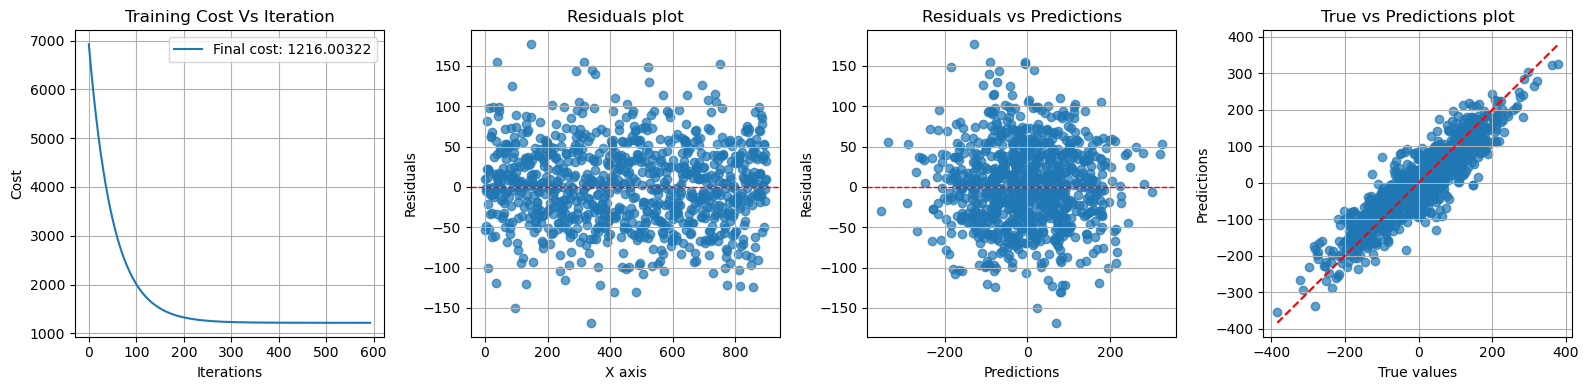

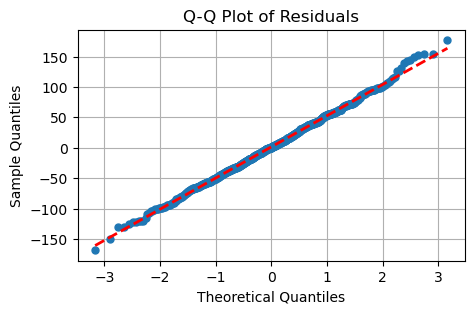

In [3]:
feature_matrix, target_1 = make_regression(n_samples=3000, n_features=3, noise=50, random_state=42)

X_train_synthetic, X_test_synthetic, y_train_synthetic, y_test_synthetic  = train_test_split(feature_matrix, target_1, test_size=0.3, random_state=100, shuffle=True)

lr_custom = CustomLinearRegression(verbose=True, learning_rate=0.01, number_of_iterations=10000, log_every=500).fit(X_train_synthetic, y_train_synthetic)
print(lr_custom.weights, lr_custom.bias)

predictions = lr_custom.predict(X_test_synthetic)

figure, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

lr_custom.plot_losses(ax=axes[0])
CustomLinearRegression.plot_residuals(y_test_synthetic - predictions, ax=axes[1])
CustomLinearRegression.plot_residuals_vs_predictions(predictions, y_test_synthetic - predictions, ax=axes[2])
CustomLinearRegression.plot_predictions_vs_true(y_test_synthetic,  predictions, ax=axes[3])

figure.tight_layout()

print(type(y_test_synthetic - predictions), (y_test_synthetic - predictions).shape)

plt.figure(figsize=(5, 3))
CustomLinearRegression.plot_qq(y_test_synthetic - predictions)

In [4]:
from sklearn.datasets import load_diabetes

data = load_diabetes(as_frame=True)

features = data.data
target = data.target

print(data.DESCR)
print('-'*100)
print(features.shape)
print(target.shape)
print('-'*100)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [5]:
features.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In [6]:
print(features.isnull().sum(axis=0))

pd.set_option('display.float_format', '{:.3f}'.format)

features.describe()

age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,442.000,442.000,442.000,442.000,442.000,442.000,442.000,442.000,442.000,442.000
mean,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000
std,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048
min,-0.107,-0.045,-0.090,-0.112,-0.127,-0.116,-0.102,-0.076,-0.126,-0.138
25%,-0.037,-0.045,-0.034,-0.037,-0.034,-0.030,-0.035,-0.039,-0.033,-0.033
50%,0.005,-0.045,-0.007,-0.006,-0.004,-0.004,-0.007,-0.003,-0.002,-0.001
75%,0.038,0.051,0.031,0.036,0.028,0.030,0.029,0.034,0.032,0.028
max,0.111,0.051,0.171,0.132,0.154,0.199,0.181,0.185,0.134,0.136


<Axes: >

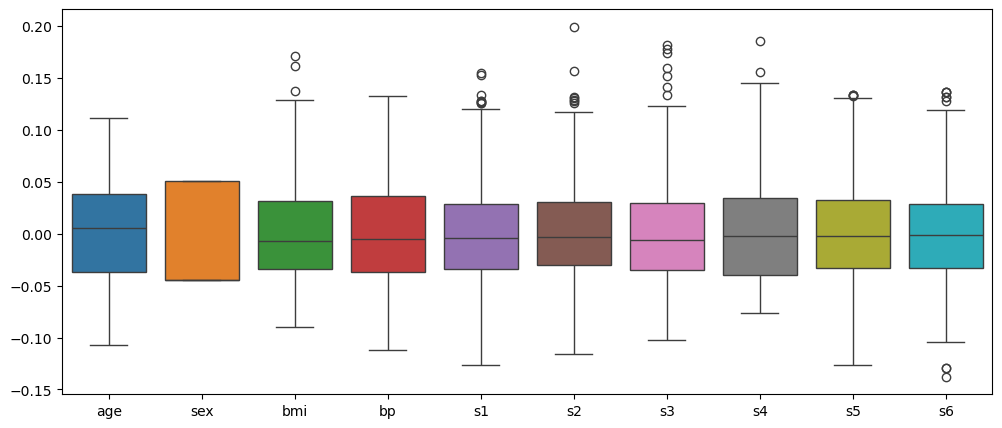

In [7]:
import seaborn as sns

plt.figure(figsize=(12, 5))
sns.boxplot(features.select_dtypes('number'))

In [8]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_absolute_error

X_train, X_test, y_train, y_test  = train_test_split(features, target, test_size=0.3, random_state=42, shuffle=True)

lr_custom = CustomLinearRegression(learning_rate=1, regularize=True, regularization_strength=0.0001).fit(X_train, y_train)
predictions_custom = lr_custom.predict(X_test)

lr_sklearn = LinearRegression().fit(X_train, y_train)
predictions_sklearn = lr_sklearn.predict(X_test)

ridge = Ridge(alpha=0.001).fit(X_train, y_train)
predictions_ridge = ridge.predict(X_test)

In [9]:
# Mean Squared Errors
mse_custom = mean_squared_error(y_test, predictions_custom)
mse_sklearn = mean_squared_error(y_test, predictions_sklearn)
mse_ridge = mean_squared_error(y_test, predictions_ridge)

# --------------------------------------------------------------------------------------------------------

#  R2 scores
r2_custom = r2_score(y_test, predictions_custom)
r2_sklearn = r2_score(y_test, predictions_sklearn)
r2_ridge = r2_score(y_test, predictions_ridge)

# --------------------------------------------------------------------------------------------------------

# Mean Absolute Value scores
mae_custom = mean_absolute_error(y_test, predictions_custom)
mae_sklearn = mean_absolute_error(y_test, predictions_sklearn)
mae_ridge = mean_absolute_error(y_test, predictions_ridge)

In [10]:
import matplotlib.pyplot as plt
import numpy as np

mse_scores = [mse_custom, mse_sklearn, mse_ridge]
r2_scores = [r2_custom, r2_sklearn, r2_ridge]
mae_scores = [mae_custom, mae_sklearn, mae_ridge]
labels = ['Custom', 'Sklearn', 'Ridge']

pd.DataFrame(index=labels, data={'MSE scores': mse_scores, 'R2 scores': r2_scores, 'MAE scores': mae_scores})

,MSE scores,R2 scores,MAE scores
Custom,2806.553,0.480,41.820
Sklearn,2821.751,0.477,41.919
Ridge,2820.614,0.478,41.898


In [11]:
residuals_custom = y_test - predictions_custom
residuals_sklearn = y_test - predictions_sklearn
residuals_ridge = y_test - predictions_ridge

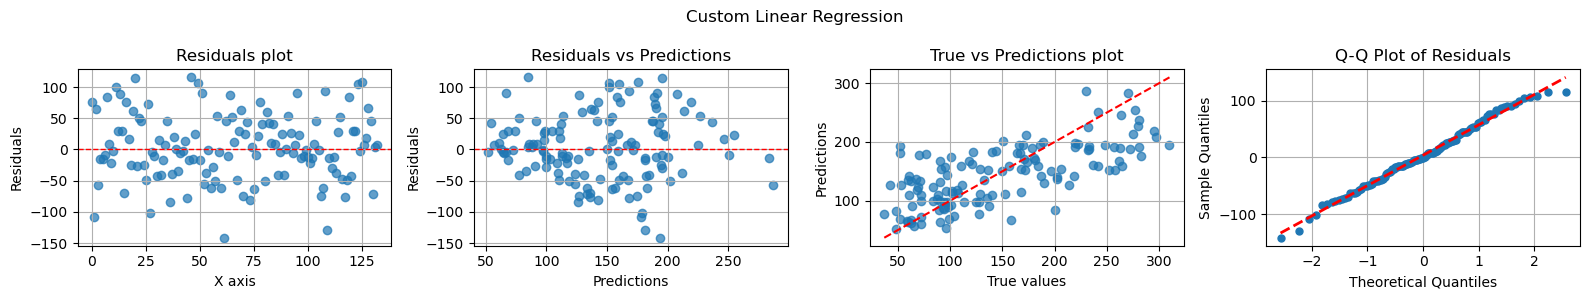

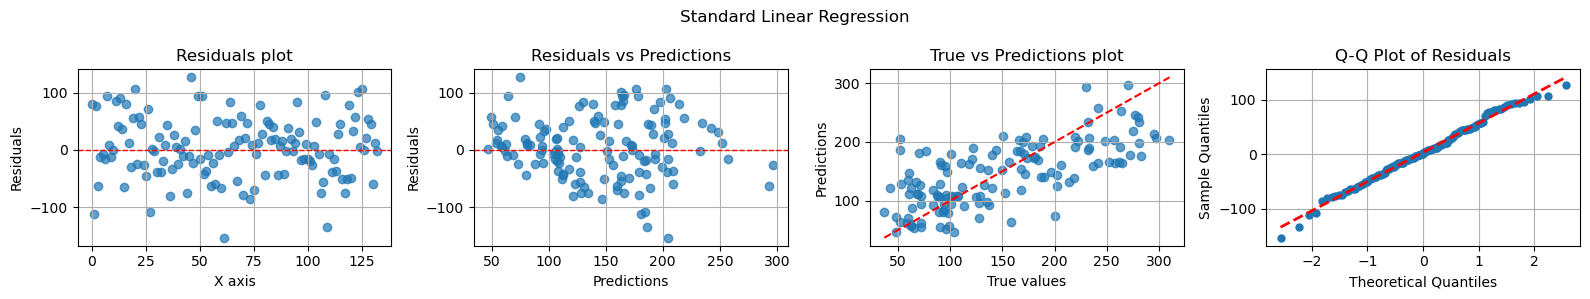

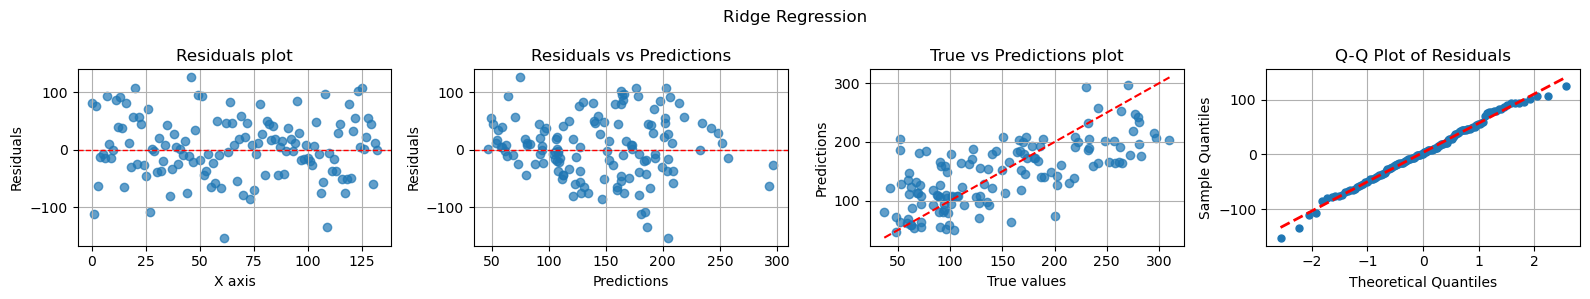

In [12]:
# CustomLinearRegression plots

figure, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 3))
figure.suptitle('Custom Linear Regression')

CustomLinearRegression.plot_residuals(residuals_custom, ax=axes[0])
CustomLinearRegression.plot_residuals_vs_predictions(predictions_custom, residuals_custom, ax=axes[1])
CustomLinearRegression.plot_predictions_vs_true(y_test, predictions_custom, ax=axes[2])
CustomLinearRegression.plot_qq(residuals_custom, ax=axes[3])

figure.tight_layout()

# --------------------------------------------------------------------------------------------------------

# Standard linear regression plots

figure, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 3))
figure.suptitle('Standard Linear Regression')

CustomLinearRegression.plot_residuals(residuals_sklearn, ax=axes[0])
CustomLinearRegression.plot_residuals_vs_predictions(predictions_ridge, residuals_sklearn, ax=axes[1])
CustomLinearRegression.plot_predictions_vs_true(y_test, predictions_sklearn, ax=axes[2])
CustomLinearRegression.plot_qq(residuals_sklearn, ax=axes[3])

figure.tight_layout()

# --------------------------------------------------------------------------------------------------------

# Ridge regression plots

figure, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 3))
figure.suptitle('Ridge Regression')

CustomLinearRegression.plot_residuals(residuals_ridge, ax=axes[0])
CustomLinearRegression.plot_residuals_vs_predictions(predictions_ridge, residuals_ridge, ax=axes[1])
CustomLinearRegression.plot_predictions_vs_true(y_test, predictions_ridge, ax=axes[2])
CustomLinearRegression.plot_qq(residuals_ridge, ax=axes[3])

figure.tight_layout()

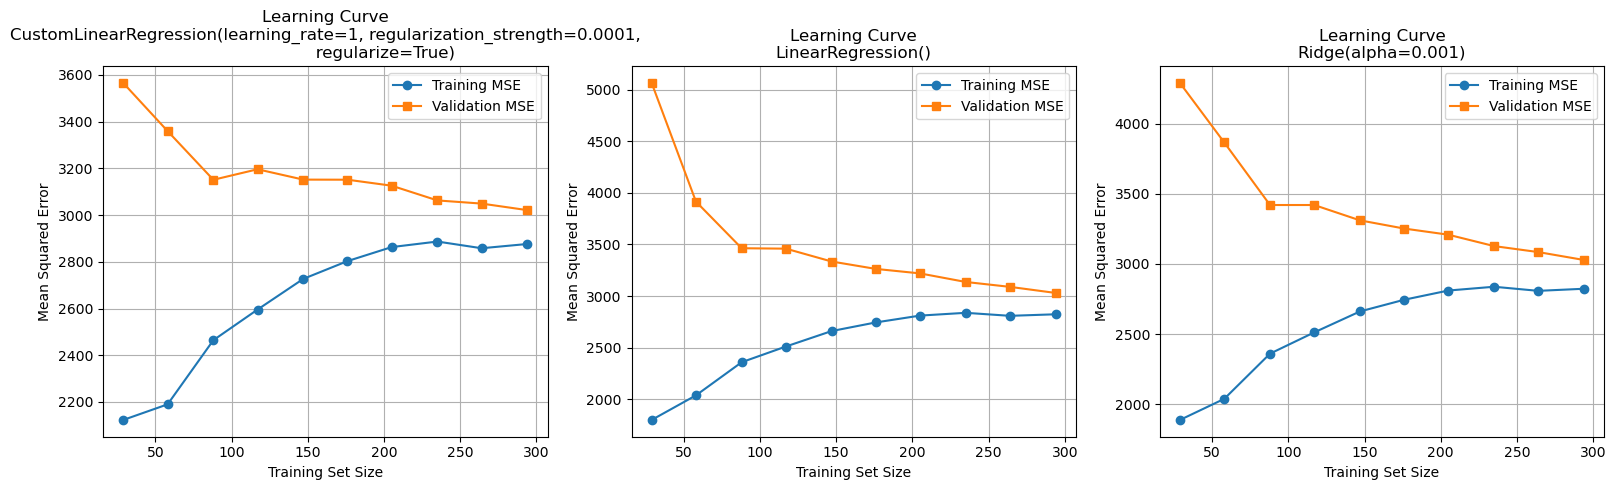

In [13]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=3, scoring='neg_mean_squared_error', ax=None):
    if ax is None:
        ax = plt.gca()

    train_sizes, train_scores, val_scores = learning_curve(
        estimator=model,
        X=X,
        y=y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring,
        shuffle=True,
        random_state=42
    )

    # Convert negative MSE to positive
    train_errors = -np.mean(train_scores, axis=1)
    val_errors = -np.mean(val_scores, axis=1)

    ax.plot(train_sizes, train_errors, label='Training MSE', marker='o')
    ax.plot(train_sizes, val_errors, label='Validation MSE', marker='s')
    ax.set_title(f'Learning Curve\n{str(model)}')
    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('Mean Squared Error')
    ax.legend()
    ax.grid()


figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

plot_learning_curve(lr_custom, features, target, ax=axes[0])
plot_learning_curve(lr_sklearn, features, target, ax=axes[1])
plot_learning_curve(ridge, features, target, ax=axes[2])

figure.tight_layout()

---
---
---

2572.6672954434252
0.5234307844381487
39.61260243424051


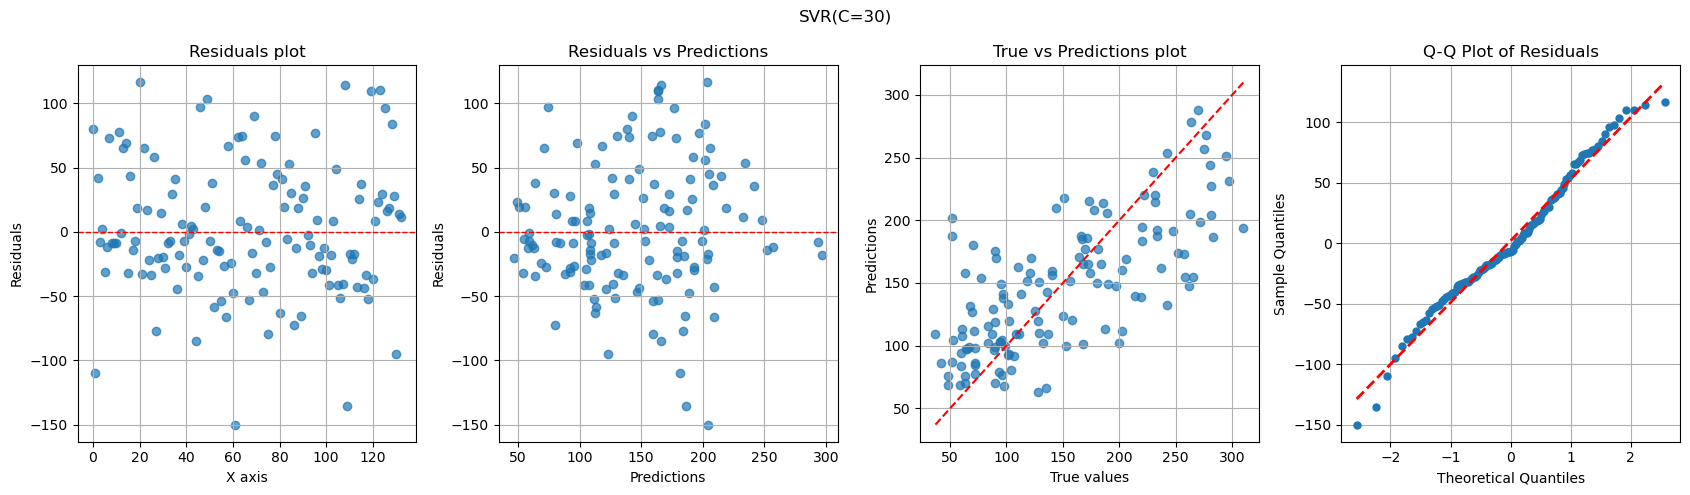

In [14]:
from sklearn.svm import SVR

svc = SVR(kernel='rbf', C=30).fit(X_train, y_train)
predictions_svc = svc.predict(X_test)

mse_svc = mean_squared_error(y_test, predictions_svc)
r2_svc = r2_score(y_test, predictions_svc)
mae_svc = mean_absolute_error(y_test, predictions_svc)

figure, axes = plt.subplots(nrows=1, ncols=4, figsize=(17, 5))
figure.suptitle(f'{str(svc)}')




CustomLinearRegression.plot_residuals(y_test - predictions_svc, ax=axes[0])
CustomLinearRegression.plot_residuals_vs_predictions(predictions_ridge, y_test - predictions_svc, ax=axes[1])
CustomLinearRegression.plot_predictions_vs_true(y_test, predictions_svc, ax=axes[2])
CustomLinearRegression.plot_qq(y_test - predictions_svc, ax=axes[3])

figure.tight_layout()

print(mse_svc)
print(r2_svc)
print(mae_svc)

In [15]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error


def kfold( X, y, model_class, n_splits=5, **model_kwargs):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mse_scores = []
    r2_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model = model_class(**model_kwargs).fit(X_train, y_train)
        y_pred = model.predict(X_val)

        mse = mean_squared_error(y_val, y_pred)
        mse_scores.append(mse)

        r2 = r2_score(y_val, y_pred)
        r2_scores.append(r2)

    mean_mse_score = np.mean(mse_scores)
    baseline_mse = np.mean((y - y.mean())**2)  # or just variance of y
    mse_change_percent  = np.round( (baseline_mse - mean_mse_score) / baseline_mse * 100,  0)

    mean_r2_score = np.mean(r2_scores)

    print(f"On average, across all folds, the variance in the validation data that the model explains is: {mean_r2_score * 100:.2f}%")
    print(f"Compared to naively just predicting the mean, the model's mean squared error changed by: {mse_change_percent:.0f}%.")

    return mean_mse_score, mean_r2_score, mse_change_percent, r2_scores, mse_scores


n_splits = 5
mean_mse_score, mean_r2_score, mse_change_percent, r2_scores, mse_scores = kfold(X_test, y_test, n_splits=n_splits,
                                                                             model_class=CustomLinearRegression, learning_rate=1,
                                                                             regularize=True, regularization_strength=0.001)

On average, across all folds, the variance in the validation data that the model explains is: 41.24%
Compared to naively just predicting the mean, the model's mean squared error changed by: 46%.


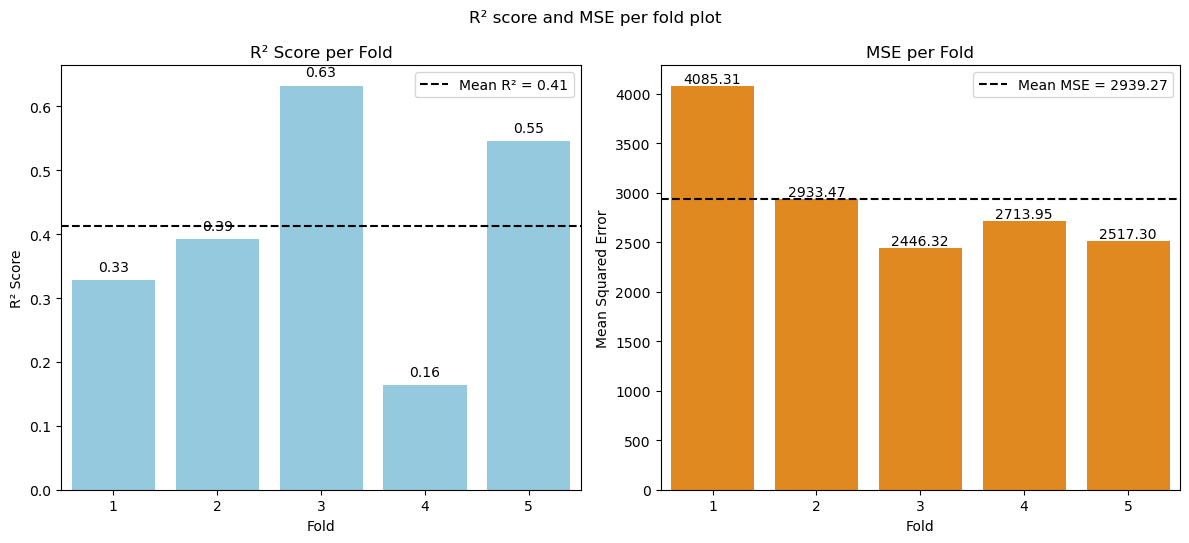

In [ ]:
    # --- Plotting ---
figure, axes = plt.subplots(1, 2, figsize=(12, 5.5))

# R2 plot
bar_r2 = sns.barplot(y=r2_scores, x=list(range(1, n_splits + 1)), ax=axes[0], color="skyblue")
axes[0].set_title('R² Score per Fold')
axes[0].set_ylabel('R² Score')
axes[0].set_xlabel('Fold')
axes[0].axhline(mean_r2_score, linestyle='--', color='black', label=f'Mean R² = {mean_r2_score:.2f}')
axes[0].legend()
for i, score in enumerate(r2_scores):
    axes[0].text(i, score + 0.01, f"{score:.2f}", ha='center', va='bottom', fontsize=10)


# MSE plot
sns.barplot(y=mse_scores, x=list(range(1, n_splits + 1)), ax=axes[1], color="darkorange")
axes[1].set_title('MSE per Fold')
axes[1].set_ylabel('Mean Squared Error')
axes[1].set_xlabel('Fold')
axes[1].axhline(y=mean_mse_score, linestyle='--', color='black', label=f'Mean MSE = {mean_mse_score:.2f}')
axes[1].legend()
for i, score in enumerate(mse_scores):
    axes[1].text(i, score + 0.01, f"{score:.2f}", ha='center', va='bottom', fontsize=10)


figure.suptitle('R² score and MSE per fold plot')
figure.tight_layout()
plt.show()